### Appendix
- Click on the links:

>1.   <a href=#imports>Libraries Imports</a>
>2.   <a href=#load>Load Data</a>
>3.   <a href=#preprocess>Data preprocess</a>
>4.   <a href=#topic>Topic Modelling</a>

##   <a name='imports'>Libraries Imports:</a>

In [1]:
import pandas as pd
import numpy as np

#for text pre-processing
import re, string, spacy, gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
#nltk.download('wordnet')
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')




C:\Users\hp\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#for text pre-processing
#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)


lemma = WordNetLemmatizer()
def lemmatizer(string):
    a=[lemma.lemmatize(i) for i in word_tokenize(string) ]
    return " ".join(a)



 ##  <a name='load'>Load Data:</a>

#df = pd.read_csv("metadata.csv",nrows=2000)

#df.to_csv("metadata2.csv")  #convert df to csv file

In [3]:
df = pd.read_csv("metadata2.csv")

In [4]:
df.head(3)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,04/07/2001,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,15/08/2000,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,25/08/2000,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


##  <a name='preprocess'>Data preprocess</a>


In [5]:
df1 = df.loc[:, ["abstract"]]
df1

,abstract
0,OBJECTIVE: This retrospective chart review des...
1,Inflammatory diseases of the respiratory tract...
2,Surfactant protein-D (SP-D) participates in th...
3,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,Respiratory syncytial virus (RSV) and pneumoni...
...,...
1995,Understanding immune responses elicited by vac...
1996,BACKGROUND: Streptococcus pneumoniae is an imp...
1997,"Cadmium is an environmentally hazardous metal,..."
1998,High-mobility-group-box chromosomal protein 1 ...


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   abstract  1914 non-null   object
dtypes: object(1)
memory usage: 15.8+ KB


In [7]:
df1 = df1.dropna(subset = ['abstract'],inplace=False)

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   abstract  1914 non-null   object
dtypes: object(1)
memory usage: 29.9+ KB


In [9]:
df1.isna().sum()

abstract    0
dtype: int64

In [10]:
df1['abstract'] = df1['abstract'].astype(str)
df1

,abstract
0,OBJECTIVE: This retrospective chart review des...
1,Inflammatory diseases of the respiratory tract...
2,Surfactant protein-D (SP-D) participates in th...
3,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,Respiratory syncytial virus (RSV) and pneumoni...
...,...
1995,Understanding immune responses elicited by vac...
1996,BACKGROUND: Streptococcus pneumoniae is an imp...
1997,"Cadmium is an environmentally hazardous metal,..."
1998,High-mobility-group-box chromosomal protein 1 ...


In [11]:
df1["clean_abstract"] = df1["abstract"].apply(lambda x: lemmatizer(stopword(preprocess(x))))
df1

,abstract,clean_abstract
0,OBJECTIVE: This retrospective chart review des...,objective retrospective chart review describes...
1,Inflammatory diseases of the respiratory tract...,inflammatory disease respiratory tract commonl...
2,Surfactant protein-D (SP-D) participates in th...,surfactant protein sp participates innate resp...
3,Endothelin-1 (ET-1) is a 21 amino acid peptide...,endothelin et amino acid peptide diverse biolo...
4,Respiratory syncytial virus (RSV) and pneumoni...,respiratory syncytial virus rsv pneumonia viru...
...,...,...
1995,Understanding immune responses elicited by vac...,understanding immune response elicited vaccine...
1996,BACKGROUND: Streptococcus pneumoniae is an imp...,background streptococcus pneumoniae important ...
1997,"Cadmium is an environmentally hazardous metal,...",cadmium environmentally hazardous metal cause ...
1998,High-mobility-group-box chromosomal protein 1 ...,high mobility group box chromosomal protein hm...


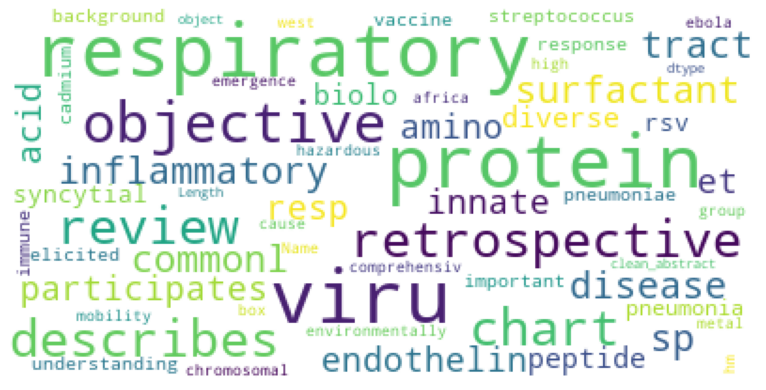

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df1['clean_abstract']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [13]:
vectorizer = CountVectorizer(stop_words='english')
doc_word = vectorizer.fit_transform(df1['clean_abstract'])
words = list(np.asarray(vectorizer.get_feature_names()))
doc_word.shape

(1914, 17182)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf1 = TfidfVectorizer(ngram_range = (1,2),stop_words='english')
doc_word1 = tfidf1.fit_transform(df1['clean_abstract'])
doc_word1.shape

(1914, 191771)

##   <a name='topic'>Topic Modle:</a>

## Build LSA Model:

In [15]:
lsa = TruncatedSVD(10,random_state=10)
doc_topic = lsa.fit_transform(doc_word)

In [16]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [17]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
virus, cell, infection, influenza, patient, protein, study, disease, viral, human

Topic  1
cell, protein, virus, expression, viral, mouse, cd, gene, replication, host

Topic  2
virus, influenza, viral, pandemic, sequence, host, rna, genome, vaccine, human

Topic  3
influenza, cell, infection, virus, patient, respiratory, lung, pandemic, il, infected

Topic  4
patient, virus, protein, viral, infection, rna, host, sequence, respiratory, genome

Topic  5
protein, influenza, pandemic, patient, vaccine, activity, cell, antibody, membrane, epitope

Topic  6
gene, expression, genome, analysis, virus, influenza, codon, rna, sequence, pcr

Topic  7
gene, infection, il, response, expression, influenza, mouse, ifn, immune, cytokine

Topic  8
vaccine, antibody, mouse, response, human, antigen, specific, epitope, immune, vaccination

Topic  9
health, virus, il, patient, public, level, disease, mouse, lung, group


## Build NMF Model:

In [18]:
nmf_model = NMF(10,random_state=10)
doc_topic = nmf_model.fit_transform(doc_word)

In [19]:
display_topics(nmf_model,vectorizer.get_feature_names(), 10)


Topic  0
cell, cd, expression, lung, mouse, human, induced, epithelial, effect, il

Topic  1
patient, severe, study, clinical, ards, respiratory, mortality, day, associated, result

Topic  2
virus, viral, human, host, sequence, rna, genome, replication, strain, infected

Topic  3
protein, rna, activity, viral, membrane, interaction, identified, domain, cellular, host

Topic  4
disease, model, data, study, method, case, result, population, infectious, human

Topic  5
influenza, pandemic, case, year, seasonal, season, vaccination, surveillance, method, data

Topic  6
gene, expression, analysis, genome, study, rna, result, pcr, sequence, level

Topic  7
infection, viral, response, ifn, infected, il, host, respiratory, immune, mouse

Topic  8
vaccine, antibody, response, mouse, hiv, specific, antigen, epitope, immune, vaccination

Topic  9
health, public, pandemic, risk, review, care, level, community, country, information


## CorEX Model:

In [20]:
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
topic_model = ct.Corex(n_hidden=5, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs= df1.clean_abstract)

In [21]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,score,score1 = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: cell,protein,expression,health,method,mouse,cellular,receptor,care,gene
1: patient,acute,respiratory,lung,distress,clinical,mortality,injury,inflammation,pulmonary
2: sequence,genome,information,transmission,evolutionary,phylogenetic,provide,evolution,specie,infectious
3: plasma,derivative,ionization,refractory,livestock,microscopic,tubular,spectrometry,related,flavonoid
4: endoplasmic,reticulum,fibroblast,proteolytic,er,pseudoknots,mabs,mab,coated,pseudoknot


In [22]:
topic_model.get_top_docs(topic=3, n_docs=2)

[('although first discovered virus previous study identified operational ribosomal frameshifting rf signal eukaryotic genomic sequence suggested role mrna stability four yeast rf signal shown promote significant mrna destabilization nonsense mediated mrna decay pathway nmd genetic evidence presented suggesting may also operate go decay pathway ngd well yeast est mrna highly unstable contains five rf signal ablation rf signal nmd stabilizes mrna change rf efficiency opposing effect steady state abundance est mrna result demonstrate endogenous rf signal function mrna destabilizing element least two molecular pathway yeast consistent current evolutionary theory phylogenetic analysis suggest rf signal rapidly evolving ci acting regulatory element identification high confidence rf signal gene eukaryotic genome surveyed suggests rf broadly used post transcriptional regulator gene expression',
  0.0),
 ('background nucleolar localization sequence nolss short targeting sequence responsible loc

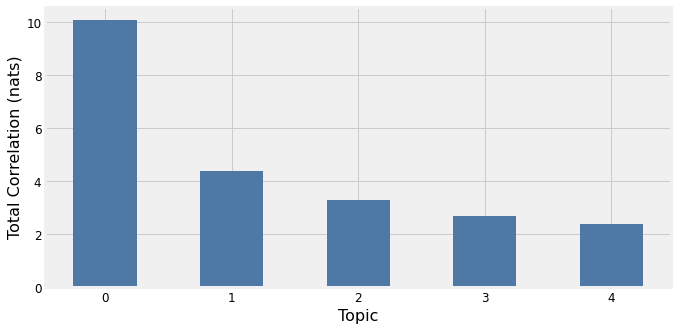

In [23]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

## Build LDA model using Sklearn


In [24]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(doc_word)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)


In [25]:
display_topics(lda_model, vectorizer.get_feature_names(), 10)


Topic  0
ceacam, dog, ifitm, cpv, cea, canine, cat, shelter, rodent, bat

Topic  1
bee, combination, csfv, neutrophil, hcc, honey, ppgalnac, rin, vector, elastase

Topic  2
virus, infection, cell, vaccine, influenza, antibody, mouse, human, viral, response

Topic  3
sp, hnrnp, amd, surfactant, vacuolation, sftpa, sbv, plant, toxin, difficile

Topic  4
activity, poultry, delivery, market, effect, plant, uptake, ai, extract, lc

Topic  5
virus, rna, sequence, protein, viral, genome, gene, structure, dna, specie

Topic  6
ga, snap, apol, glycyrrhizin, atgus, hip, hbz, gfp, lrtd, exosome

Topic  7
disease, health, data, method, study, model, population, result, pandemic, influenza

Topic  8
patient, influenza, infection, respiratory, case, study, clinical, severe, associated, day

Topic  9
cell, protein, gene, expression, il, response, study, activity, infection, pathway


In [26]:
 #Materialize the sparse data
data_dense = doc_word.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.5107864211617538 %


In [27]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(doc_word))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(doc_word))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1989589.7758913008
Perplexity:  2907.1108361469805
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## Tune number of topics and learning decay (controls learning rate) using GridSearchCV

In [28]:
# Define Search Param
search_params = {'n_components': [4,5,6,7,8,10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(random_state =10)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(doc_word)

GridSearchCV(estimator=LatentDirichletAllocation(random_state=10),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [4, 5, 6, 7, 8, 10]})

In [29]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_word))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 4}
Best Log Likelihood Score:  -466996.325139888
Model Perplexity:  3235.6511338709647


In [30]:
display_topics(best_lda_model, vectorizer.get_feature_names(), 20)


Topic  0
disease, health, influenza, data, model, study, pandemic, method, result, population, risk, case, public, outbreak, transmission, epidemic, used, contact, infectious, based

Topic  1
virus, protein, cell, gene, viral, infection, human, rna, host, expression, antibody, study, sequence, response, genome, replication, type, specific, using, activity

Topic  2
patient, cell, infection, influenza, virus, study, disease, respiratory, associated, result, lung, mouse, response, clinical, case, il, level, severe, acute, day

Topic  3
method, pcr, assay, detection, sample, virus, using, dna, study, used, result, clinical, test, time, based, rt, pathogen, acid, specie, high


_______________________________________________________________________________________

#### Topic 0 -----> (challenges based of Covid-19's)
disease, health, influenza, data, model, study, pandemic, method, outcome, population, risk, condition, general, outbreak, transmission, epidemic, user, contact, contagious, existing

#### Topic 1 ----->( Virus-RNA)
virus, protein, cell, gene, viral, infection, human, RNA, host, expression, antibody, study, sequence, response, genome, replication, type, specific, use, activity

#### Topic 2 ----->(Other diseases based of Covid-19's)
sick, cell, infection, influenza, virus, study, disease, respiratory, associated, result, lung, mouse, response, clinical, case, il, level, acute, acute, day

#### Topic 3 -----> (Searching for treatment of Covid-19's)
method, pcr, assay, detection, sample, virus, using, dna, study, used, result, clinical, test, time, basis, RT, pathogen, acid, quality, high


## View the dominant topic probability in each document

In [31]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(doc_word)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df1))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Doc0,0.000000,0.000000,0.990000,0.000000,2
Doc1,0.060000,0.260000,0.680000,0.000000,2
Doc2,0.000000,0.580000,0.410000,0.000000,1
Doc3,0.010000,0.370000,0.620000,0.010000,2
Doc4,0.000000,0.700000,0.300000,0.000000,1
Doc5,0.230000,0.760000,0.000000,0.000000,1
Doc6,0.030000,0.000000,0.960000,0.000000,2
Doc7,0.330000,0.000000,0.540000,0.130000,2
Doc8,0.000000,0.160000,0.830000,0.000000,2
Doc9,0.990000,0.000000,0.000000,0.000000,0


## Topic - doc distribution

In [32]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,717
1,2,562
2,0,476
3,3,159


[717 562 476 159]


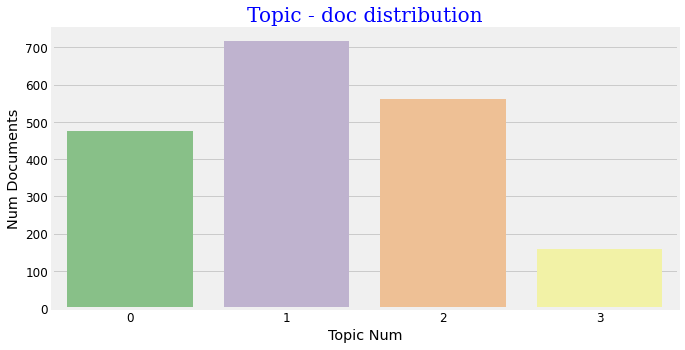

In [33]:
plt.figure(figsize=(10,5))
values_column = df_topic_distribution.loc[:,'Num Documents']
values = values_column.values
print(values)

sns.barplot(x=df_topic_distribution['Topic Num'], y=df_topic_distribution['Num Documents'], palette = sns.color_palette('Accent'))
plt.title('Topic - doc distribution',family='serif',fontsize = 20,loc='center',color='b')
plt.show()

## Visualize the top words per topic (their overall frequency in the original doc vs their frequency in the topic) 


In [38]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, doc_word, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      269.562408 -124.803398       1        1  34.416327
2        1.782994 -295.079681       2        1  31.510101
0      220.811432 -343.832123       3        1  25.593790
3       50.533993  -76.050934       4        1   8.479783, topic_info=            Term         Freq        Total Category  logprob  loglift
11386    patient  1361.000000  1361.000000  Default  30.0000  30.0000
12559    protein  1414.000000  1414.000000  Default  29.0000  29.0000
2335        cell  2152.000000  2152.000000  Default  28.0000  28.0000
6715      health   642.000000   642.000000  Default  27.0000  27.0000
7817   influenza  1290.000000  1290.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
4138   diagnosis    52.353028   208.003215   Topic4  -6.0016   1.0879
6920        high    63.664646   574.887196   Topic4  -5.8060   0.2669
685     analysis    58.254913   690.084813   Topic4  -5.8948  -0.0045
14130   sequence    48.697814   505.983001   Topic4  -6.0740   0.1266
15368     target    47.692297   311.924235   Topic4  -6.0949   0.5895

[339 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
154        1  0.605011      acid
154        2  0.086430      acid
154        3  0.079228      acid
154        4  0.230481      acid
206        1  0.556873  activity
...      ...       ...       ...
16963      3  0.959320  wildlife
17082      1  0.062672      year
17082      2  0.616272      year
17082      3  0.284634      year
17082      4  0.036559      year

[680 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

## Show top n keywords for each topic

In [39]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,disease,health,influenza,data,model,study,pandemic,method,result,population,risk,case,public,outbreak,transmission
Topic 1,virus,protein,cell,gene,viral,infection,human,rna,host,expression,antibody,study,sequence,response,genome
Topic 2,patient,cell,infection,influenza,virus,study,disease,respiratory,associated,result,lung,mouse,response,clinical,case
Topic 3,method,pcr,assay,detection,sample,virus,using,dna,study,used,result,clinical,test,time,based


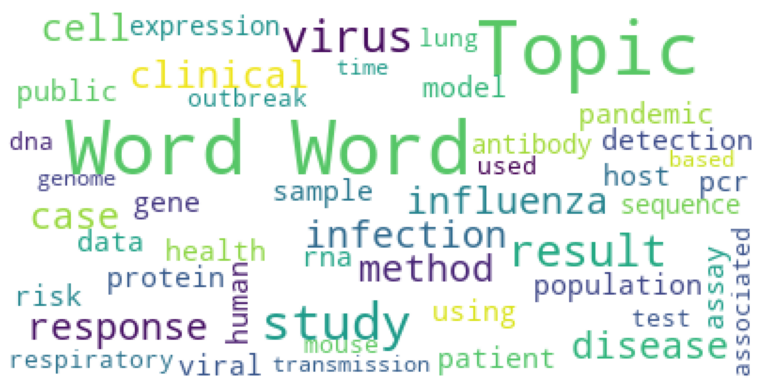

In [40]:
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_topic_keywords[:'Topic 4']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [41]:
X = df_document_topic.loc[:, ['Topic0', 'Topic1','Topic2' , 'Topic3']]
X

,Topic0,Topic1,Topic2,Topic3
Doc0,0.00,0.00,0.99,0.00
Doc1,0.06,0.26,0.68,0.00
Doc2,0.00,0.58,0.41,0.00
Doc3,0.01,0.37,0.62,0.01
Doc4,0.00,0.70,0.30,0.00
...,...,...,...,...
Doc1909,0.09,0.00,0.91,0.00
Doc1910,0.00,0.00,0.27,0.72
Doc1911,0.00,0.00,0.99,0.00
Doc1912,0.00,0.65,0.34,0.00


In [42]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_over_std = ss.fit_transform(X)

In [43]:
from sklearn.cluster import KMeans
km = KMeans()
km.fit(X_over_std)

KMeans()

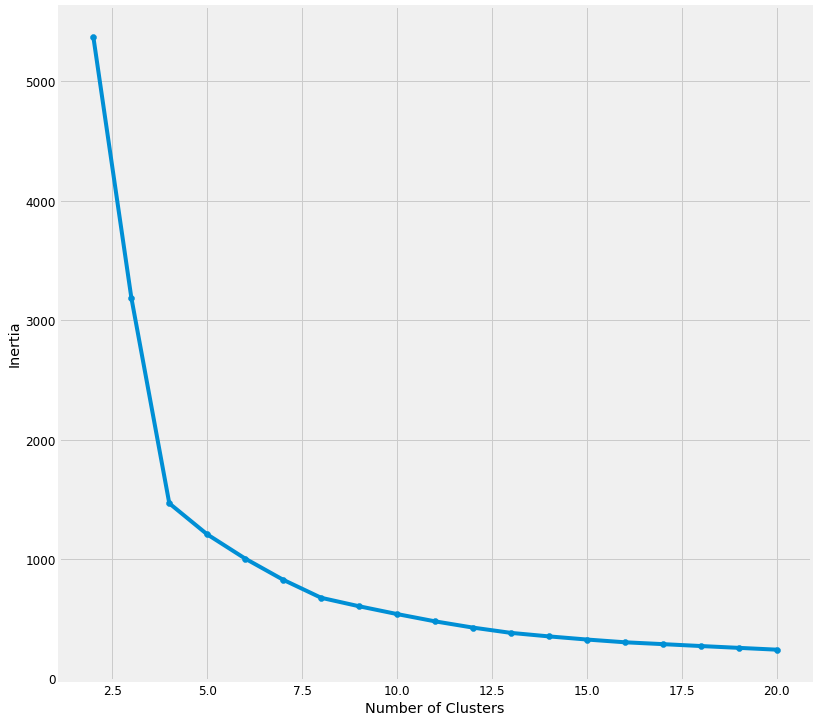

In [44]:
inertia = []
list_num_clusters = list(range(2,21))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X_over_std)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [45]:
from sklearn.metrics import silhouette_score
for num_clusters in range(2,11):
    km = KMeans(n_clusters=num_clusters)
    km.fit(X_over_std)
    
    cluster_labels = km.fit_predict(X_over_std)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_over_std, cluster_labels)
    print(
        km,
        "For n_clusters =",
        num_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

KMeans(n_clusters=2) For n_clusters = 2 The average silhouette_score is : 0.3464288974047076
KMeans(n_clusters=3) For n_clusters = 3 The average silhouette_score is : 0.4905042935378716
KMeans(n_clusters=4) For n_clusters = 4 The average silhouette_score is : 0.5809900085670475
KMeans(n_clusters=5) For n_clusters = 5 The average silhouette_score is : 0.5173806350728256
KMeans(n_clusters=6) For n_clusters = 6 The average silhouette_score is : 0.5209453701408722
KMeans(n_clusters=7) For n_clusters = 7 The average silhouette_score is : 0.5198223266715132
KMeans() For n_clusters = 8 The average silhouette_score is : 0.5467866380860242
KMeans(n_clusters=9) For n_clusters = 9 The average silhouette_score is : 0.5537813594665645
KMeans(n_clusters=10) For n_clusters = 10 The average silhouette_score is : 0.5642758622603313


In [46]:
km = KMeans(n_clusters=4,random_state=10)
km.fit(X_over_std)

KMeans(n_clusters=4, random_state=10)

In [47]:
df_document_topic["cluster"] = km.predict(X_over_std)
df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,dominant_topic,cluster
Doc0,0.00,0.00,0.99,0.00,2,2
Doc1,0.06,0.26,0.68,0.00,2,2
Doc2,0.00,0.58,0.41,0.00,1,1
Doc3,0.01,0.37,0.62,0.01,2,2
Doc4,0.00,0.70,0.30,0.00,1,1
Doc5,0.23,0.76,0.00,0.00,1,1
Doc6,0.03,0.00,0.96,0.00,2,2
Doc7,0.33,0.00,0.54,0.13,2,2
Doc8,0.00,0.16,0.83,0.00,2,2
Doc9,0.99,0.00,0.00,0.00,0,3


In [48]:
df2= pd.DataFrame(km.cluster_centers_, columns = X.columns)
df2

,Topic0,Topic1,Topic2,Topic3
0,-0.446722,-0.559242,-0.619280,2.745431
1,-0.474830,1.139216,-0.515477,-0.279064
2,-0.576310,-0.698196,1.432872,-0.307350
3,1.609483,-0.756278,-0.629247,-0.287748


In [49]:
df2.to_csv("Topic.csv")  #convert df to csv file